# LLM Steering of Pre-Trained RL Agents Toward Out-of-Distribution Goals

A research implementation investigating how large language models (LLMs) can expand the objective space of pre-trained reinforcement learning agents, enabling open-ended behavior in complex environments without retraining.

## Implementation Details

The codebase is organized around the research methodology described in our technical report:

```
├── main.ipynb                       # Main experimental notebook
├── crafter                          # Clone of the Crafter repo
├── dreamerv3                        # Clone of the Dreamer V3 (part 1)
├── embodied                         # Clone of the Dreamer V3 (part 2)
├── utils/                           # Research implementation modules
│   ├── dreamer_setup.py             # Pre-trained DreamerV3 agent loading  
│   ├── env_setup.py                 # Crafter environment configuration
│   ├── llm_interaction.py           # LLM steering logic & intervention schedules
│   ├── episode_inspector.py         # Behavioral analysis & performance tracking
│   ├── create_colormap.py           # Create proper color map for game screenshots
│   ├── pathfinding.py               # A* pathfinding for LLM-to-action translation
│   ├── crafter_semantic.py          # Semantic world state extraction
│   └── player_movement.py           # Navigation utilities
├── logdir/crafter_selected/         # Pre-trained DreamerV3 checkpoints
└── requirements.txt                 # Required packages
```

## Core Components

### 1. LLM Steering System (`utils/llm_interaction.py`)

Implements the conditional intervention logic described in our technical report:

```python
def LLM_steering(env, agent, steps_to_run=500, initial_steps=20, cooldown_steps=70):
    """
    Conditionally override pre-trained RL agent with LLM-generated actions
    for out-of-distribution construction objectives.
    """
```
Based on the technical report, the LLM receives:
- Current semantic map analysis
- Available objects in field of view  
- Player inventory state
- Task-specific instructions for bridge/tunnel construction

### 2. Episode Inspector (`utils/episode_inspector.py`)

Comprehensive analysis matching the behavioral metrics reported in our paper:

```python
inspection_results = inspect_baseline_episode(
    agent=agent, max_steps=2000, inspection_seed=888
)
```

### 3. Semantic World Understanding (`utils/crafter_semantic.py`)

Extracts the semantic information needed for LLM decision-making:

```python
mat_ids, obj_ids, semantic_map, player_pos, facing = inspect_crafter_semantics()
```

### 4. Pathfinding for LLM-to-Action Translation (`utils/pathfinding.py`)

Converts high-level LLM construction plans into executable action sequences:

```python
pathfinder = PathFinding(walkable_tiles)
movement_sequence = pathfinder.find(grid, start_pos, target_item)
```

## Acknowledgments

- **DreamerV3**: Original implementation by Danijar Hafner et al.
- **Crafter Environment**: Created by Danijar Hafner for RL research
- **Pathfinding**: A* implementation inspired by HappyEureka/mcrafter project
- **LLM Integration**: GPT-4.1 access provided by OpenAI
- **Research Support**: Technical discussions and feedback from the RL community



In [1]:
# Loading the Trained Dreamer Agent and Environment
# ========================================================================
from utils.dreamer_setup import load_dreamer_agent, ACTION_ID_TO_NAME
from utils.env_setup import make_env


# Load Dreamer agent and environment
logdir = 'logdir/crafter_selected'
ckpt_rel = 'ckpt/20250711T001149F202929' # Specify the path to your own DreamerV3-trained policy (should include 'agent.pkl') 
                                         # and match with latest in ckpt/latest


# ========== CONFIGURATION ==========
AGENT_SEED = 0
ENV_SEED = 888 # can be changed in other cells too
# ===================================

seed = AGENT_SEED
agent, obs_space, act_space, env_from_load = load_dreamer_agent(logdir, ckpt_rel, seed)

# Create environment using the modular setup
env = make_env(ENV_SEED)

print(f"Environment: {type(env)}")
print(f"Base environment: {type(env.env)}")
print(f"Agent seed: {AGENT_SEED}")
print(f"Environment seed: {ENV_SEED}")

# Test reset
obs = env.reset()
print(f"Reset returns: {type(obs)}, obs shape: {obs[0].shape if isinstance(obs, tuple) else obs.shape}")

# Get action and observation spaces
act_space = env.action_space
obs_space = {
    'image': obs[0] if isinstance(obs, tuple) else obs,
    'reward': 0.0,
    'is_first': True,
    'is_last': False,
    'is_terminal': False
}
print(f"Action space: {act_space}")
print(f"Observation space keys: {list(obs_space.keys())}")
print(f"Image shape: {obs_space['image'].shape}")

# Test a single step to verify API compatibility
test_action = env.action_space.sample()
print(f"Testing step with action: {test_action}")
step_result = env.step(test_action)
print(f"Step returns {len(step_result)} values: {[type(x) for x in step_result]}")

# Reset for clean state
obs = env.reset()
obs_space = {
    'image': obs[0] if isinstance(obs, tuple) else obs,
    'reward': 0.0,
    'is_first': True,
    'is_last': False,
    'is_terminal': False
}

[WARN] JAX set_cache_dir not available in this JAX version. Skipping persistent cache setup.
Observations
  image            Space(uint8, shape=(64, 64, 3), low=0, high=255)
  reward           Space(float32, shape=(), low=-inf, high=inf)
  is_first         Space(bool, shape=(), low=False, high=True)
  is_last          Space(bool, shape=(), low=False, high=True)
  is_terminal      Space(bool, shape=(), low=False, high=True)
Actions
  action           Space(int32, shape=(), low=0, high=17)
Extras
  consec           Space(int32, shape=(), low=-2147483648, high=2147483647)
  stepid           Space(uint8, shape=(20,), low=0, high=255)
  dyn/deter        Space(float32, shape=(8192,), low=-inf, high=inf)
  dyn/stoch        Space(float32, shape=(32, 64), low=-inf, high=inf)
JAX devices (1): [TFRT_CPU_0]
Policy devices: TFRT_CPU_0
Train devices:  TFRT_CPU_0
Initializing parameters...
Optimizer opt has 165,965,075 params:
    95,495,168 dyn
    20,282,115 dec
    12,850,431 val
    12,606,481 po

In [2]:
# Loading utilities for plotting and semantic inspection
# ========================================================================

from utils.crafter_semantic import inspect_crafter_semantics
from utils.create_colormap import create_colormap

# Call the function to inspect and get mappings
mat_ids, obj_ids, semantic_map, player_pos, facing = inspect_crafter_semantics(verbose=True)

# Check available material and object IDs for color mapping
print("Material IDs:", mat_ids)
print("Object IDs:", obj_ids)
crafter_colormap = create_colormap()


INFO KEYS: dict_keys(['inventory', 'achievements', 'discount', 'semantic', 'player_pos', 'reward'])
{'achievements': {'collect_coal': 0,
                  'collect_diamond': 0,
                  'collect_drink': 0,
                  'collect_iron': 0,
                  'collect_sapling': 0,
                  'collect_stone': 0,
                  'collect_wood': 0,
                  'defeat_skeleton': 0,
                  'defeat_zombie': 0,
                  'eat_cow': 0,
                  'eat_plant': 0,
                  'make_iron_pickaxe': 0,
                  'make_iron_sword': 0,
                  'make_stone_pickaxe': 0,
                  'make_stone_sword': 0,
                  'make_wood_pickaxe': 0,
                  'make_wood_sword': 0,
                  'place_furnace': 0,
                  'place_plant': 0,
                  'place_stone': 0,
                  'place_table': 0,
                  'wake_up': 0},
 'discount': 1.0,
 'inventory': {'coal': 0,
               'di

In [3]:
# Baseline Episode Inspector 
# ========================================================================

from utils.episode_inspector import inspect_baseline_episode, save_inspection_log

# Configuration - change this seed to inspect different episodes
INSPECTION_SEED = ENV_SEED 

print("Starting baseline episode inspection...")
print(f"You can change INSPECTION_SEED to explore different episodes")
print()

# Run the inspection using the modular function
inspection_results = inspect_baseline_episode(
    agent=agent,
    obs_space=obs_space, 
    act_space=act_space,
    env=env,
    action_id_to_name=ACTION_ID_TO_NAME,
    inspection_seed=INSPECTION_SEED,
    max_steps=2000,  # Reasonable episode length for inspection
    verbose=True     # Set to False for less detailed output
)

# Save detailed log for further analysis
log_filename = save_inspection_log(inspection_results)

print(f"Baseline episode inspection complete!")
print()
print("To inspect a different episode, change INSPECTION_SEED and re-run this cell")
print("Use the inspection_results variable to access all collected data")

Starting baseline episode inspection...
You can change INSPECTION_SEED to explore different episodes

BASELINE EPISODE INSPECTION (Seed: 888)
Starting baseline episode with seed 888
Initial observation shape: (64, 64, 3)

Step    0: Move Up          |  | Inventory: 36 items | Total reward: 0.00
Step    4: Do (Interact)    | +1.00 reward  | Inventory: 37 items | Total reward: 1.00
Step   11: Do (Interact)    | +1.00 reward  | Inventory: 39 items | Total reward: 2.00
Step   26: Place Table      | +0.80 reward  | Inventory: 34 items | Total reward: 2.80
Step   27: Make Wood Pickaxe | +1.00 reward  | Inventory: 34 items | Total reward: 3.80
Step   32: Do (Interact)    | +1.00 reward  | Inventory: 33 items | Total reward: 4.80
Step   33: Place Plant      | +1.00 reward  | Inventory: 32 items | Total reward: 5.80
Step   63: Do (Interact)    | +1.00 reward  | Inventory: 28 items | Total reward: 6.50
Step   65: Place Stone      | +1.00 reward  | Inventory: 27 items | Total reward: 7.50
Step   

Running 500 steps with LLM conditions...
LLM will be called after step 20 if conditions are met
Cooldown period: 70 steps between LLM calls

 Step 20: LLM conditions met!
   Inventory: {'health': 9, 'food': 9, 'drink': 8, 'energy': 9, 'sapling': 0, 'wood': 0, 'stone': 0, 'coal': 0, 'iron': 0, 'diamond': 0, 'wood_pickaxe': 1, 'stone_pickaxe': 0, 'iron_pickaxe': 0, 'wood_sword': 1, 'stone_sword': 0, 'iron_sword': 0}
   Has pickaxe: True
   Stone/Water in POV: True

 Current state at step 21:
 Obs shape: (64, 64, 3), Full semantic shape: (64, 64)
 Player at: (36, 26)
 Inventory: {'health': 9, 'food': 9, 'drink': 8, 'energy': 9, 'sapling': 0, 'wood': 0, 'stone': 0, 'coal': 0, 'iron': 0, 'diamond': 0, 'wood_pickaxe': 1, 'stone_pickaxe': 0, 'iron_pickaxe': 0, 'wood_sword': 1, 'stone_sword': 0, 'iron_sword': 0}
 LLM calls made: 1
 Player FOV shape: (29, 37), Player FOV pos: (14, 18)
 FOV bounds in world: rows 18-55, cols 12-41

 INITIAL STATE - Before LLM object selection:


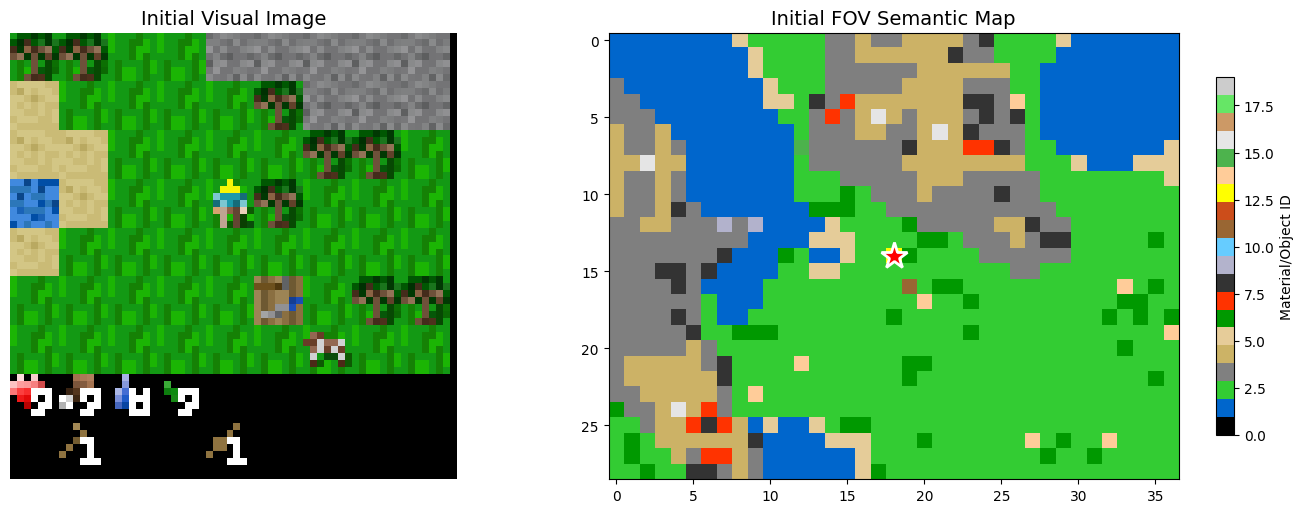


 Asking LLM to select an object from the scene...
 LLM response:
The player is standing on grassy terrain surrounded by trees, stone, water, and various resources, with some hostile mobs like skeletons and zombies visible in the area.

3
 LLM description: The player is standing on grassy terrain surrounded by trees, stone, water, and various resources, with some hostile mobs like skeletons and zombies visible in the area.
 LLM selected object ID: 3

 Finding path to stone (ID 3)...
 Path found: ['up', 'up', 'up']

 Moving player to stone...
Starting movement sequence: ['up', 'up', 'up']
Starting position: (36, 26), facing: 0 (North)
Step 1: Moving up (action 3), now facing: 0 (North)
  New position: (36, 25), facing: 0 (North)
Step 2: Moving up (action 3), now facing: 0 (North)
  New position: (36, 24), facing: 0 (North)
Step 3: Moving up (action 3), now facing: 0 (North)
  New position: (36, 24), facing: 0 (North)
Movement completed. Final position: (36, 24), final facing: 0 (North)


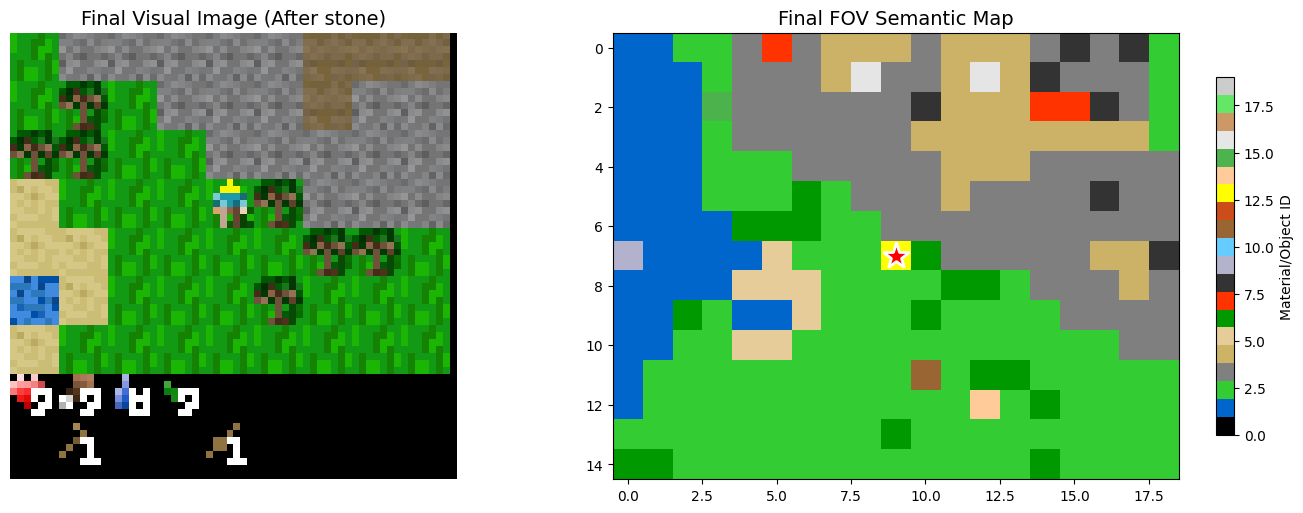


 Movement Summary:
  Step 1: Moved up to (36, 25) (action 3), facing 0 (North)
  Step 2: Moved up to (36, 24) (action 3), facing 0 (North)
  Step 3: Moved up to (36, 24) (action 3), facing 0 (North)

 Successfully moved to stone!

 Asking LLM for move sequence to build bridge or tunnel at new location...
 LLM move sequence response:
The player is facing north and is adjacent to a stone area, with more stone blocks forming a horizontal band; the player can carve a p-shaped tunnel through the stone by moving right, up, up, left, down.

right, up, up, left, down
 Scene description: The player is facing north and is adjacent to a stone area, with more stone blocks forming a horizontal band; the player can carve a p-shaped tunnel through the stone by moving right, up, up, left, down.
🔨 Moves: ['right', 'up', 'up', 'left', 'down']


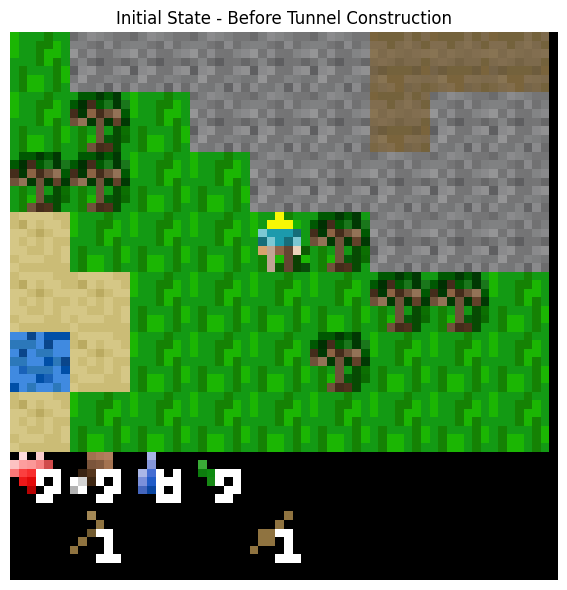

Construction Step 1/5: right
  Collected stone at [36 24]


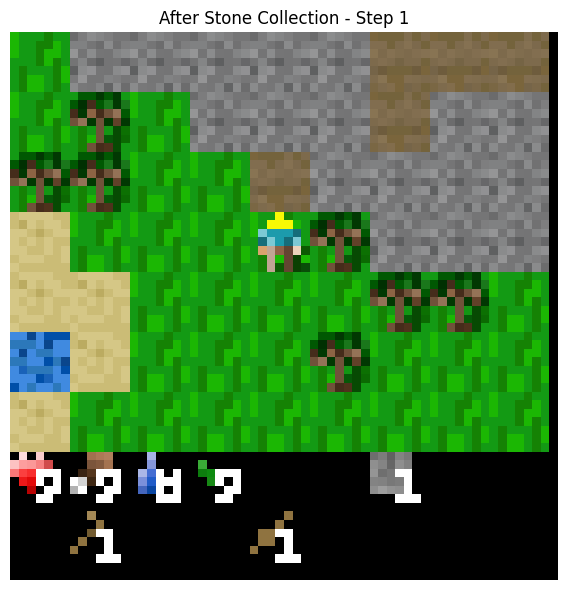

  Moved right to [36 24]


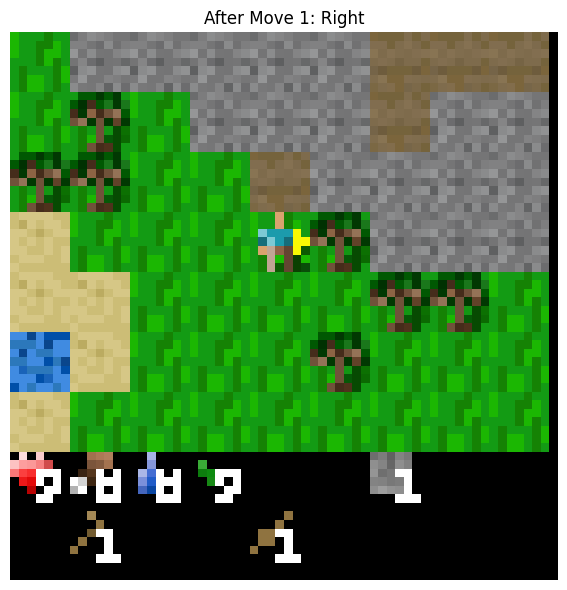

Construction Step 2/5: up
  Collected stone at [36 24]


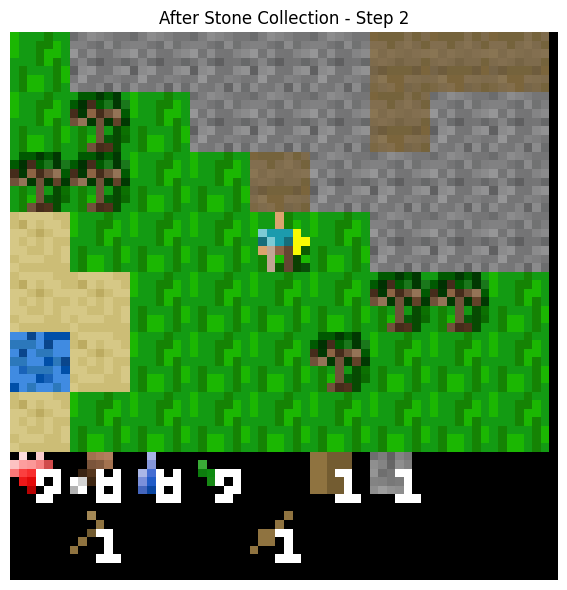

  Moved up to [36 23]


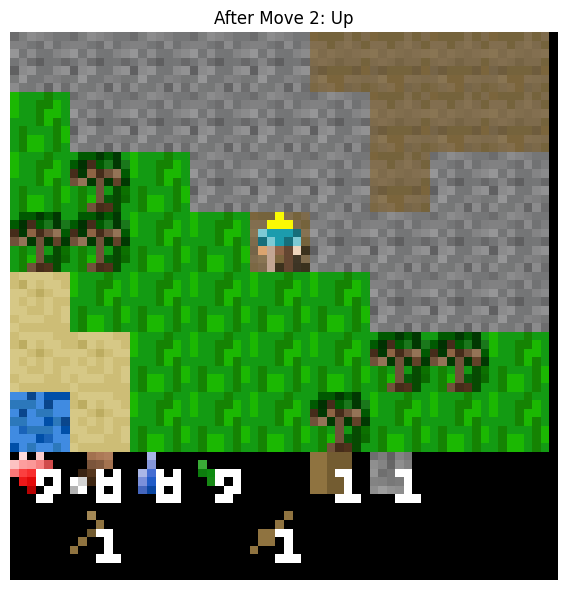

Construction Step 3/5: up
  Collected stone at [36 23]


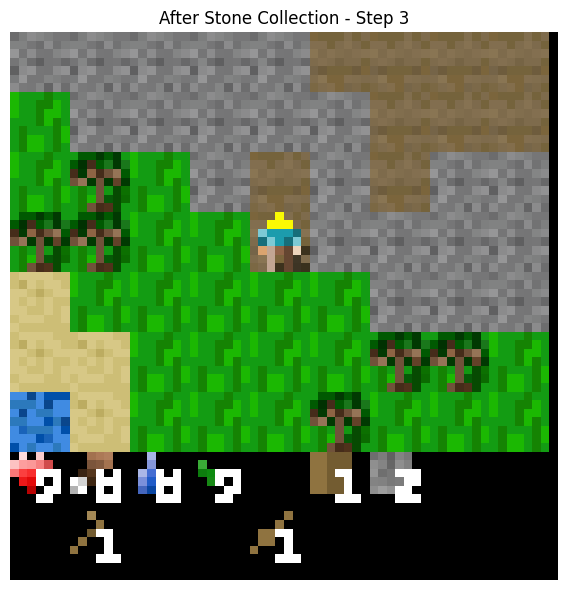

  Moved up to [36 22]


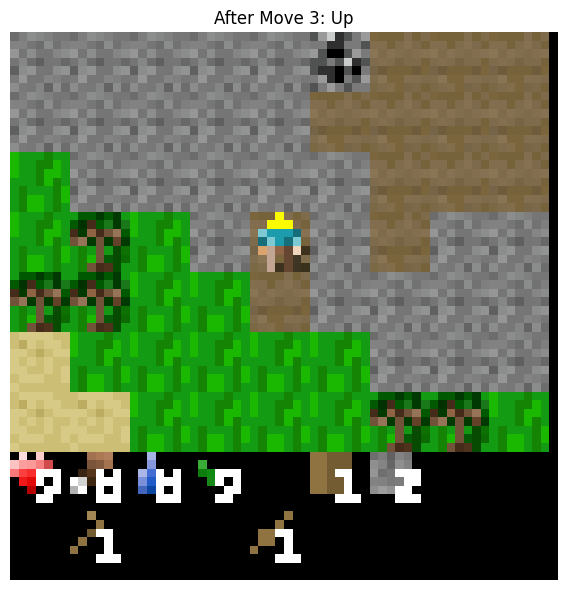

Construction Step 4/5: left
  Collected stone at [36 22]


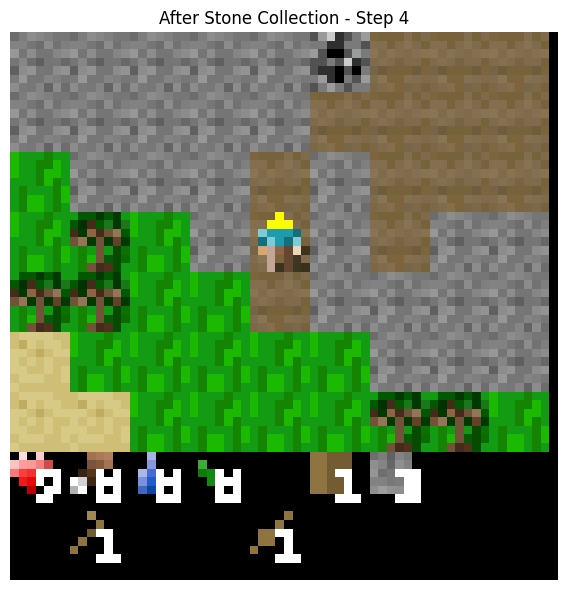

  Moved left to [36 22]


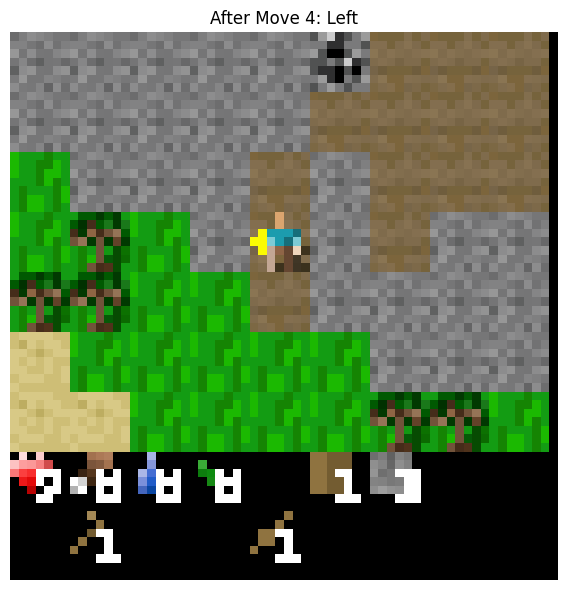

Construction Step 5/5: down
  Collected stone at [36 22]


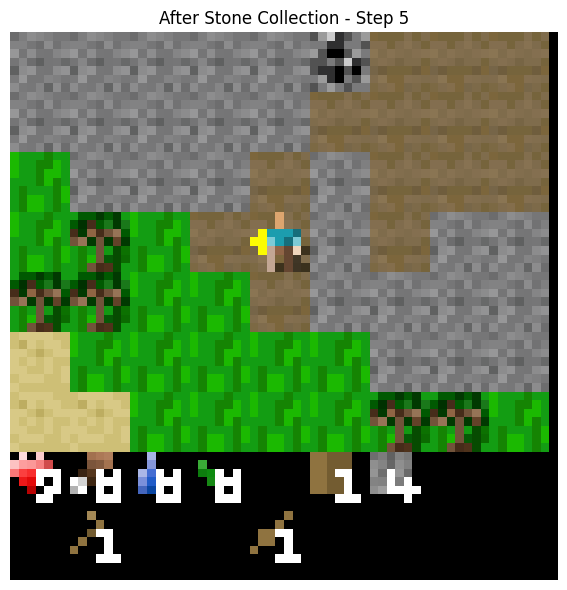

  Moved down to [36 23]


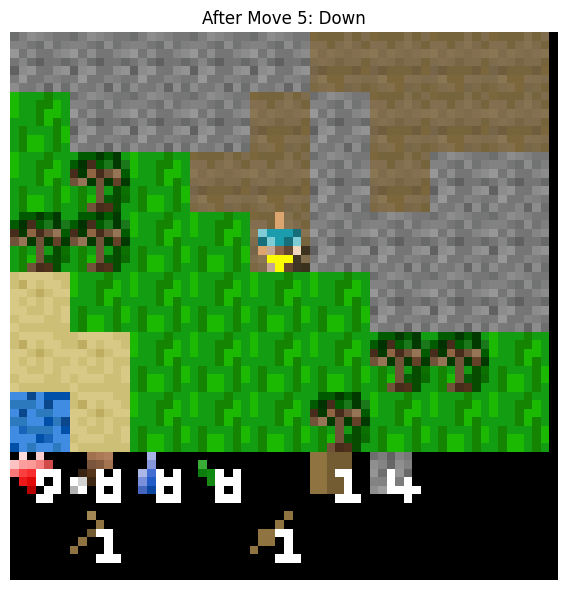

Construction completed: 5 moves executed
 LLM move sequence processed. Log: [('right', array([36, 24])), ('up', array([36, 23])), ('up', array([36, 22])), ('left', array([36, 22])), ('down', array([36, 23]))]

 FINAL STATE - After building tunnel:


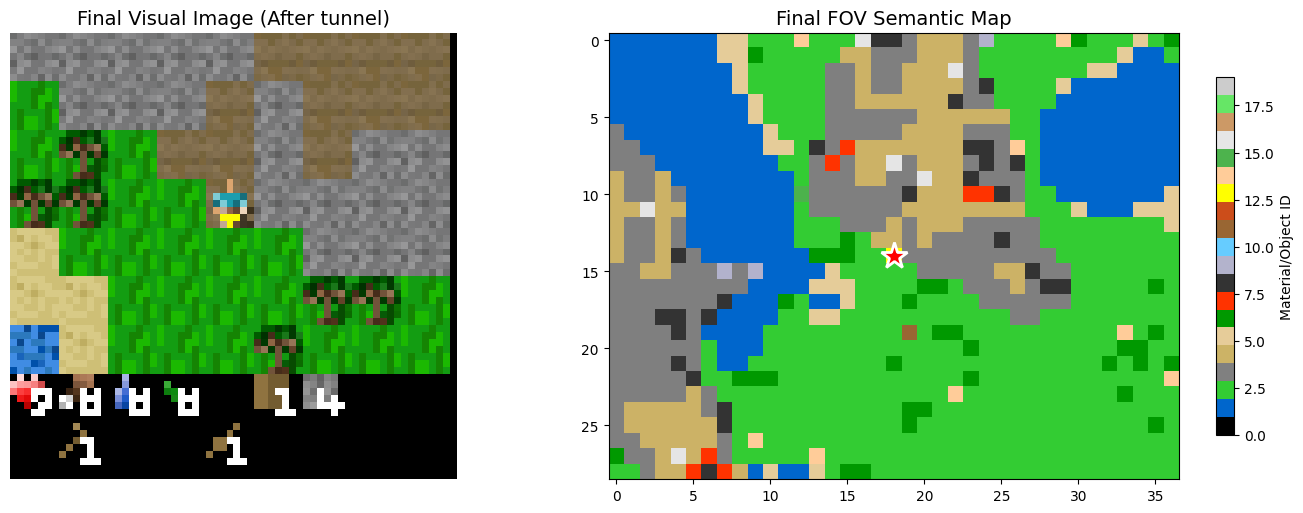

 Environment terminated at step 84


In [8]:
# LLM Steering Agent for Construction and Pathfinding
# ========================================================================

import os
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

from utils.pathfinding import PathFinding
from utils.llm_interaction import LLM_steering

from utils.player_movement import move_player_by_path, extract_player_fov_semantic, analyze_semantic_map_fov, process_llm_moves



# Set OpenAI API key (make sure to set this in your environment)
os.environ['OPENAI_API_KEY'] = 'your-api-key-here' 


# Call the function with all required parameters
result = LLM_steering(
    env=env, 
    agent=agent, 
    mat_ids=mat_ids, 
    obj_ids=obj_ids,
    crafter_colormap=crafter_colormap,
    extract_player_fov_semantic=extract_player_fov_semantic,
    analyze_semantic_map_fov=analyze_semantic_map_fov,
    move_player_by_path=move_player_by_path,
    process_llm_moves=process_llm_moves,
    PathFinding=PathFinding,
    steps_to_run=500, 
    initial_steps=20, 
    cooldown_steps=70,
    input_seed=ENV_SEED,  # Use the same seed as prev cells for consistency
    show_navigation_images=False,      # Don't show pathfinding steps
    show_construction_images=True      # Show construction steps
)